# Matrix Factorization with SimEc
In this notebook are some examples to show that SimEc can be used to compute the SVD or eigendecomposition of a matrix.

Performing an SVD and eigendecomposition of a matrix with neural networks was first described by A. Cichocki (et al.) in 1992 in [this paper (SVD)](http://ieeexplore.ieee.org/document/133134/?reload=true) and [this paper (eigendecomposition)](https://link.springer.com/article/10.1007/BF00201437).

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(28)
import keras

from simec import SimilarityEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def msqe(A, B):
    # compute the mean squared error between two matrices A and B
    # obviously, A and B should be the same shape...
    return np.mean((A - B) ** 2)

In [3]:
# generate a random matrix
n_input = 500
n_output = 700
A = np.random.rand(n_input, n_output)
# compute its SVD
U, s, Vh = np.linalg.svd(A, full_matrices=True)
U.shape, s.shape, Vh.shape

((500, 500), (500,), (700, 700))

In [4]:
# make the eigenvalues of A a bit more extreme
S = np.zeros((n_input, n_output))
s[0] = s[1]+1
s[:10] *= 50.
s[10:20] *= 20.
s[20:100] *= 10.
S[:n_input, :n_input] = np.diag(s)
# recompute A and scale it to be in a somewhat reasonable range
A = np.dot(U, np.dot(S, Vh))
A = A/np.max(np.abs(A))
# recompute SVD again
U, s, Vh = np.linalg.svd(A, full_matrices=True)
S = np.zeros((n_input, n_output))
S[:n_input, :n_input] = np.diag(s)

In [5]:
# check that eigenvectors are orthogonal
np.dot(Vh[:100,:], Vh[:100,:].T)

array([[  1.00000000e+00,  -5.45570533e-16,   1.30971622e-16, ...,
          6.93889390e-17,   1.25767452e-17,  -1.38777878e-17],
       [ -5.45570533e-16,   1.00000000e+00,   2.48065457e-16, ...,
         -5.20417043e-17,  -9.19403442e-17,  -2.94902991e-17],
       [  1.30971622e-16,   2.48065457e-16,   1.00000000e+00, ...,
          3.46944695e-18,   7.97972799e-17,   8.58688121e-17],
       ..., 
       [  6.93889390e-17,  -5.20417043e-17,   3.46944695e-18, ...,
          1.00000000e+00,  -1.04083409e-15,   3.79904441e-16],
       [  1.25767452e-17,  -9.19403442e-17,   7.97972799e-17, ...,
         -1.04083409e-15,   1.00000000e+00,  -2.30067701e-16],
       [ -1.38777878e-17,  -2.94902991e-17,   8.58688121e-17, ...,
          3.79904441e-16,  -2.30067701e-16,   1.00000000e+00]])

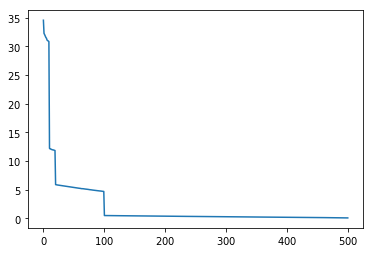

In [6]:
# inspect eigenvalues
plt.plot(s)

### SVD of a random matrix

In [7]:
# mean squared error of approximation decreases with more embedding dim
for e_dim in [2, 10, 25, 50, 75, 100, 250, 400, 500]:
    print("mse with %3i e_dim: %.8f" % (e_dim, msqe(A, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim], Vh[:e_dim,:])))))

mse with   2 e_dim: 0.03285552
mse with  10 e_dim: 0.01045687
mse with  25 e_dim: 0.00588207
mse with  50 e_dim: 0.00367207
mse with  75 e_dim: 0.00175594
mse with 100 e_dim: 0.00009198
mse with 250 e_dim: 0.00002807
mse with 400 e_dim: 0.00000396
mse with 500 e_dim: 0.00000000


In [8]:
# factorize the matrix with a simec
X = np.eye(n_input)
mses = []
e_dims =  [2, 10, 25, 50, 75, 100, 250, 400, 500, 750, 1000]
l_rates = {400: 0.004, 500: 0.0034, 750: 0.0032, 1000: 0.003}
for e_dim in e_dims:
    model = SimilarityEncoder(n_input, e_dim, n_output, orth_reg=0.001 if e_dim > 500 else 0., opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X, A, epochs=50)
    mse = msqe(A, model.predict(X))
    mses.append(mse)
    print("mse with %4i e_dim: %.8f" % (e_dim, mse))
for i, e_dim in enumerate(e_dims):
    print("mse with %4i e_dim: %.8f" % (e_dim, mses[i]))

Epoch 1/50
500/500 [==============================] - 1s 1ms/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 71us/step - loss: 0.0388
Epoch 3/50
500/500 [==============================] - 0s 75us/step - loss: 0.0377
Epoch 4/50
500/500 [==============================] - 0s 68us/step - loss: 0.0365
Epoch 5/50
500/500 [==============================] - 0s 73us/step - loss: 0.0360
Epoch 6/50
500/500 [==============================] - 0s 87us/step - loss: 0.0359
Epoch 7/50
500/500 [==============================] - 0s 81us/step - loss: 0.0359
Epoch 8/50
500/500 [==============================] - 0s 87us/step - loss: 0.0358
Epoch 9/50
500/500 [==============================] - 0s 68us/step - loss: 0.0358
Epoch 10/50
500/500 [==============================] - 0s 118us/step - loss: 0.0358
Epoch 11/50
500/500 [==============================] - 0s 105us/step - loss: 0.0358
Epoch 12/50
500/500 [==============================] - 0s 76us/step - loss: 0.0357
Epoch 13/50


500/500 [==============================] - 0s 62us/step - loss: 0.0061
Epoch 48/50
500/500 [==============================] - 0s 75us/step - loss: 0.0060
Epoch 49/50
500/500 [==============================] - 0s 75us/step - loss: 0.0059
Epoch 50/50
500/500 [==============================] - 0s 89us/step - loss: 0.0059
mse with   50 e_dim: 0.00471228
Epoch 1/50
500/500 [==============================] - 0s 272us/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 78us/step - loss: 0.0360
Epoch 3/50
500/500 [==============================] - 0s 98us/step - loss: 0.0352
Epoch 4/50
500/500 [==============================] - 0s 93us/step - loss: 0.0340
Epoch 5/50
500/500 [==============================] - 0s 98us/step - loss: 0.0324
Epoch 6/50
500/500 [==============================] - 0s 84us/step - loss: 0.0303
Epoch 7/50
500/500 [==============================] - 0s 83us/step - loss: 0.0277
Epoch 8/50
500/500 [==============================] - 0s 89us/step - loss

Epoch 45/50
500/500 [==============================] - 0s 86us/step - loss: 0.0034
Epoch 46/50
500/500 [==============================] - 0s 86us/step - loss: 0.0032
Epoch 47/50
500/500 [==============================] - 0s 96us/step - loss: 0.0031
Epoch 48/50
500/500 [==============================] - 0s 91us/step - loss: 0.0030
Epoch 49/50
500/500 [==============================] - 0s 87us/step - loss: 0.0029
Epoch 50/50
500/500 [==============================] - 0s 74us/step - loss: 0.0028
mse with  100 e_dim: 0.00130659
Epoch 1/50
500/500 [==============================] - 0s 328us/step - loss: 0.0401
Epoch 2/50
500/500 [==============================] - 0s 114us/step - loss: 0.0356
Epoch 3/50
500/500 [==============================] - 0s 76us/step - loss: 0.0329
Epoch 4/50
500/500 [==============================] - 0s 76us/step - loss: 0.0292
Epoch 5/50
500/500 [==============================] - 0s 87us/step - loss: 0.0243
Epoch 6/50
500/500 [==============================] - 0s 8

500/500 [==============================] - 0s 91us/step - loss: 0.0019
Epoch 44/50
500/500 [==============================] - 0s 76us/step - loss: 0.0018
Epoch 45/50
500/500 [==============================] - 0s 83us/step - loss: 0.0018
Epoch 46/50
500/500 [==============================] - 0s 90us/step - loss: 0.0018
Epoch 47/50
500/500 [==============================] - 0s 88us/step - loss: 0.0018
Epoch 48/50
500/500 [==============================] - 0s 102us/step - loss: 0.0017
Epoch 49/50
500/500 [==============================] - 0s 77us/step - loss: 0.0017
Epoch 50/50
500/500 [==============================] - 0s 77us/step - loss: 0.0017
mse with  400 e_dim: 0.00018387
Epoch 1/50
500/500 [==============================] - 0s 374us/step - loss: 0.0417
Epoch 2/50
500/500 [==============================] - 0s 87us/step - loss: 0.0361
Epoch 3/50
500/500 [==============================] - 0s 93us/step - loss: 0.0332
Epoch 4/50
500/500 [==============================] - 0s 95us/step -

In [9]:
# factorize the matrix with a simec - transpose works just as well
# this time we use the embedding we learned before as the weights of the last layer
# to get the mapping function for the other side of the equation (which is of course kind of useless
# here since we don't actually map feature vectors but only identiy vectors)
X1 = np.eye(n_input)
X2 = np.eye(n_output)
mses1 = []
mses2 = []
mses3 = []
e_dims =  [2, 10, 25, 50, 75, 100, 250, 400, 500, 750, 1000]
for e_dim in e_dims:
    model = SimilarityEncoder(n_input, e_dim, n_output, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X1, A, epochs=50)
    mse = msqe(A, model.predict(X1))
    mses1.append(mse)
    print("mse with %4i e_dim: %.8f" % (e_dim, mse))
    Y1 = model.transform(X1)
    model = SimilarityEncoder(n_output, e_dim, n_input, W_ll=Y1.T, wll_frozen=True, opt=keras.optimizers.Adamax(lr=0.005 if e_dim <= 250 else l_rates[e_dim]))
    model.fit(X2, A.T, epochs=50)
    mse = msqe(A.T, model.predict(X2))
    mses2.append(mse)
    print("mse with %4i e_dim: %.8f" % (e_dim, mse))
    Y2 = model.transform(X2)
    # the dot product of both embeddings should also approximate A
    mse = msqe(A, np.dot(Y1, Y2.T))
    mses3.append(mse)
for i, e_dim in enumerate(e_dims):
    print("mse with %4i e_dim: %.8f / %.8f / %.8f" % (e_dim, mses1[i], mses2[i], mses3[i]))

Epoch 1/50
500/500 [==============================] - 0s 418us/step - loss: 0.0392
Epoch 2/50
500/500 [==============================] - 0s 88us/step - loss: 0.0388
Epoch 3/50
500/500 [==============================] - 0s 81us/step - loss: 0.0378
Epoch 4/50
500/500 [==============================] - 0s 94us/step - loss: 0.0366
Epoch 5/50
500/500 [==============================] - 0s 93us/step - loss: 0.0360
Epoch 6/50
500/500 [==============================] - 0s 96us/step - loss: 0.0359
Epoch 7/50
500/500 [==============================] - 0s 80us/step - loss: 0.0359
Epoch 8/50
500/500 [==============================] - 0s 88us/step - loss: 0.0358
Epoch 9/50
500/500 [==============================] - 0s 82us/step - loss: 0.0358
Epoch 10/50
500/500 [==============================] - 0s 97us/step - loss: 0.0358
Epoch 11/50
500/500 [==============================] - 0s 84us/step - loss: 0.0358
Epoch 12/50
500/500 [==============================] - 0s 66us/step - loss: 0.0358
Epoch 13/50


700/700 [==============================] - 0s 76us/step - loss: 0.0245
Epoch 48/50
700/700 [==============================] - 0s 91us/step - loss: 0.0243
Epoch 49/50
700/700 [==============================] - 0s 88us/step - loss: 0.0242
Epoch 50/50
700/700 [==============================] - 0s 80us/step - loss: 0.0241
mse with   10 e_dim: 0.02229033
Epoch 1/50
500/500 [==============================] - 0s 517us/step - loss: 0.0394
Epoch 2/50
500/500 [==============================] - 0s 101us/step - loss: 0.0368
Epoch 3/50
500/500 [==============================] - 0s 97us/step - loss: 0.0358
Epoch 4/50
500/500 [==============================] - 0s 86us/step - loss: 0.0355
Epoch 5/50
500/500 [==============================] - 0s 89us/step - loss: 0.0351
Epoch 6/50
500/500 [==============================] - 0s 87us/step - loss: 0.0345
Epoch 7/50
500/500 [==============================] - 0s 85us/step - loss: 0.0338
Epoch 8/50
500/500 [==============================] - 0s 89us/step - los

700/700 [==============================] - 0s 66us/step - loss: 0.0200
Epoch 44/50
700/700 [==============================] - 0s 83us/step - loss: 0.0199
Epoch 45/50
700/700 [==============================] - 0s 77us/step - loss: 0.0198
Epoch 46/50
700/700 [==============================] - 0s 76us/step - loss: 0.0197
Epoch 47/50
700/700 [==============================] - 0s 102us/step - loss: 0.0196
Epoch 48/50
700/700 [==============================] - 0s 79us/step - loss: 0.0195
Epoch 49/50
700/700 [==============================] - 0s 94us/step - loss: 0.0194
Epoch 50/50
700/700 [==============================] - 0s 85us/step - loss: 0.0193
mse with   50 e_dim: 0.01449267
Epoch 1/50
500/500 [==============================] - 0s 618us/step - loss: 0.0396
Epoch 2/50
500/500 [==============================] - 0s 89us/step - loss: 0.0362
Epoch 3/50
500/500 [==============================] - 0s 88us/step - loss: 0.0353
Epoch 4/50
500/500 [==============================] - 0s 94us/step -

700/700 [==============================] - 0s 100us/step - loss: 0.0190
Epoch 40/50
700/700 [==============================] - 0s 78us/step - loss: 0.0189
Epoch 41/50
700/700 [==============================] - 0s 97us/step - loss: 0.0189
Epoch 42/50
700/700 [==============================] - 0s 84us/step - loss: 0.0188
Epoch 43/50
700/700 [==============================] - 0s 75us/step - loss: 0.0187
Epoch 44/50
700/700 [==============================] - 0s 96us/step - loss: 0.0187
Epoch 45/50
700/700 [==============================] - 0s 79us/step - loss: 0.0186
Epoch 46/50
700/700 [==============================] - 0s 76us/step - loss: 0.0185
Epoch 47/50
700/700 [==============================] - 0s 109us/step - loss: 0.0185
Epoch 48/50
700/700 [==============================] - 0s 76us/step - loss: 0.0184
Epoch 49/50
700/700 [==============================] - 0s 88us/step - loss: 0.0184
Epoch 50/50
700/700 [==============================] - 0s 84us/step - loss: 0.0183
mse with  100 

700/700 [==============================] - 0s 86us/step - loss: 0.0185
Epoch 35/50
700/700 [==============================] - 0s 96us/step - loss: 0.0184
Epoch 36/50
700/700 [==============================] - 0s 93us/step - loss: 0.0183
Epoch 37/50
700/700 [==============================] - 0s 105us/step - loss: 0.0183
Epoch 38/50
700/700 [==============================] - 0s 95us/step - loss: 0.0182
Epoch 39/50
700/700 [==============================] - 0s 85us/step - loss: 0.0182
Epoch 40/50
700/700 [==============================] - 0s 88us/step - loss: 0.0181
Epoch 41/50
700/700 [==============================] - 0s 75us/step - loss: 0.0181
Epoch 42/50
700/700 [==============================] - 0s 83us/step - loss: 0.0181
Epoch 43/50
700/700 [==============================] - 0s 89us/step - loss: 0.0181
Epoch 44/50
700/700 [==============================] - 0s 86us/step - loss: 0.0180
Epoch 45/50
700/700 [==============================] - 0s 87us/step - loss: 0.0180
Epoch 46/50
700

700/700 [==============================] - 0s 87us/step - loss: 0.0190
Epoch 29/50
700/700 [==============================] - 0s 94us/step - loss: 0.0189
Epoch 30/50
700/700 [==============================] - 0s 108us/step - loss: 0.0188
Epoch 31/50
700/700 [==============================] - 0s 104us/step - loss: 0.0187
Epoch 32/50
700/700 [==============================] - 0s 89us/step - loss: 0.0186
Epoch 33/50
700/700 [==============================] - 0s 98us/step - loss: 0.0186
Epoch 34/50
700/700 [==============================] - 0s 105us/step - loss: 0.0185
Epoch 35/50
700/700 [==============================] - 0s 105us/step - loss: 0.0184
Epoch 36/50
700/700 [==============================] - 0s 97us/step - loss: 0.0184
Epoch 37/50
700/700 [==============================] - 0s 105us/step - loss: 0.0183
Epoch 38/50
700/700 [==============================] - 0s 95us/step - loss: 0.0183
Epoch 39/50
700/700 [==============================] - 0s 105us/step - loss: 0.0182
Epoch 40/5

#### Dealing with missing values
A regular SVD can not be computed for a matrix with missing values, therefore these need to be filled by some values, e.g. the average of the matrix. SimEc on the other hand can compute the backpropagation error considering only the available entries of the matrix, which means it can easily handle about 50% missing values without seeing major performance decreases and consistently outperforms the regular SVD (results would probably be even better with more careful hyperparameter tuning, e.g. using some regularization).

0.0
Epoch 1/60
500/500 [==============================] - 1s 1ms/step - loss: 0.0377
Epoch 2/60
500/500 [==============================] - 0s 93us/step - loss: 0.0361
Epoch 3/60
500/500 [==============================] - 0s 86us/step - loss: 0.0359
Epoch 4/60
500/500 [==============================] - 0s 98us/step - loss: 0.0358
Epoch 5/60
500/500 [==============================] - 0s 95us/step - loss: 0.0356
Epoch 6/60
500/500 [==============================] - 0s 117us/step - loss: 0.0353
Epoch 7/60
500/500 [==============================] - 0s 92us/step - loss: 0.0348
Epoch 8/60
500/500 [==============================] - 0s 88us/step - loss: 0.0342
Epoch 9/60
500/500 [==============================] - 0s 89us/step - loss: 0.0337
Epoch 10/60
500/500 [==============================] - 0s 102us/step - loss: 0.0334
Epoch 11/60
500/500 [==============================] - 0s 88us/step - loss: 0.0333
Epoch 12/60
500/500 [==============================] - 0s 89us/step - loss: 0.0332
Epoch 13

500/500 [==============================] - 0s 92us/step - loss: 0.0329
Epoch 18/60
500/500 [==============================] - 0s 92us/step - loss: 0.0329
Epoch 19/60
500/500 [==============================] - 0s 83us/step - loss: 0.0329
Epoch 20/60
500/500 [==============================] - 0s 79us/step - loss: 0.0329
Epoch 21/60
500/500 [==============================] - 0s 82us/step - loss: 0.0329
Epoch 22/60
500/500 [==============================] - 0s 82us/step - loss: 0.0329
Epoch 23/60
500/500 [==============================] - 0s 102us/step - loss: 0.0329
Epoch 24/60
500/500 [==============================] - 0s 77us/step - loss: 0.0329
Epoch 25/60
500/500 [==============================] - 0s 80us/step - loss: 0.0328
Epoch 26/60
500/500 [==============================] - 0s 96us/step - loss: 0.0328
Epoch 27/60
500/500 [==============================] - 0s 95us/step - loss: 0.0328
Epoch 28/60
500/500 [==============================] - 0s 80us/step - loss: 0.0328
Epoch 29/60
500

500/500 [==============================] - 0s 94us/step - loss: 0.0329
Epoch 34/60
500/500 [==============================] - 0s 124us/step - loss: 0.0329
Epoch 35/60
500/500 [==============================] - 0s 100us/step - loss: 0.0329
Epoch 36/60
500/500 [==============================] - 0s 96us/step - loss: 0.0329
Epoch 37/60
500/500 [==============================] - 0s 113us/step - loss: 0.0329
Epoch 38/60
500/500 [==============================] - 0s 87us/step - loss: 0.0329
Epoch 39/60
500/500 [==============================] - 0s 81us/step - loss: 0.0329
Epoch 40/60
500/500 [==============================] - 0s 78us/step - loss: 0.0329
Epoch 41/60
500/500 [==============================] - 0s 103us/step - loss: 0.0329
Epoch 42/60
500/500 [==============================] - 0s 83us/step - loss: 0.0329
Epoch 43/60
500/500 [==============================] - 0s 73us/step - loss: 0.0329
Epoch 44/60
500/500 [==============================] - 0s 93us/step - loss: 0.0329
Epoch 45/60


500/500 [==============================] - 0s 93us/step - loss: 0.0318
Epoch 50/60
500/500 [==============================] - 0s 101us/step - loss: 0.0318
Epoch 51/60
500/500 [==============================] - 0s 84us/step - loss: 0.0318
Epoch 52/60
500/500 [==============================] - 0s 107us/step - loss: 0.0318
Epoch 53/60
500/500 [==============================] - 0s 98us/step - loss: 0.0318
Epoch 54/60
500/500 [==============================] - 0s 109us/step - loss: 0.0318
Epoch 55/60
500/500 [==============================] - 0s 78us/step - loss: 0.0318
Epoch 56/60
500/500 [==============================] - 0s 97us/step - loss: 0.0318
Epoch 57/60
500/500 [==============================] - 0s 97us/step - loss: 0.0318
Epoch 58/60
500/500 [==============================] - 0s 105us/step - loss: 0.0318
Epoch 59/60
500/500 [==============================] - 0s 76us/step - loss: 0.0318
Epoch 60/60
500/500 [==============================] - 0s 75us/step - loss: 0.0318
[0.032992550

500/500 [==============================] - 0s 85us/step - loss: 0.0354
Epoch 3/60
500/500 [==============================] - 0s 67us/step - loss: 0.0335
Epoch 4/60
500/500 [==============================] - 0s 81us/step - loss: 0.0305
Epoch 5/60
500/500 [==============================] - 0s 88us/step - loss: 0.0268
Epoch 6/60
500/500 [==============================] - 0s 89us/step - loss: 0.0230
Epoch 7/60
500/500 [==============================] - 0s 94us/step - loss: 0.0198
Epoch 8/60
500/500 [==============================] - 0s 91us/step - loss: 0.0172
Epoch 9/60
500/500 [==============================] - 0s 89us/step - loss: 0.0153
Epoch 10/60
500/500 [==============================] - 0s 97us/step - loss: 0.0142
Epoch 11/60
500/500 [==============================] - 0s 99us/step - loss: 0.0135
Epoch 12/60
500/500 [==============================] - 0s 92us/step - loss: 0.0127
Epoch 13/60
500/500 [==============================] - 0s 91us/step - loss: 0.0120
Epoch 14/60
500/500 [==

500/500 [==============================] - 0s 99us/step - loss: 0.0108
Epoch 19/60
500/500 [==============================] - 0s 101us/step - loss: 0.0107
Epoch 20/60
500/500 [==============================] - 0s 97us/step - loss: 0.0107
Epoch 21/60
500/500 [==============================] - 0s 95us/step - loss: 0.0107
Epoch 22/60
500/500 [==============================] - 0s 83us/step - loss: 0.0107
Epoch 23/60
500/500 [==============================] - 0s 79us/step - loss: 0.0107
Epoch 24/60
500/500 [==============================] - 0s 91us/step - loss: 0.0107
Epoch 25/60
500/500 [==============================] - 0s 99us/step - loss: 0.0106
Epoch 26/60
500/500 [==============================] - 0s 94us/step - loss: 0.0106
Epoch 27/60
500/500 [==============================] - 0s 97us/step - loss: 0.0106
Epoch 28/60
500/500 [==============================] - 0s 86us/step - loss: 0.0106
Epoch 29/60
500/500 [==============================] - 0s 107us/step - loss: 0.0106
Epoch 30/60
50

500/500 [==============================] - 0s 92us/step - loss: 0.0148
Epoch 35/60
500/500 [==============================] - 0s 72us/step - loss: 0.0148
Epoch 36/60
500/500 [==============================] - 0s 76us/step - loss: 0.0147
Epoch 37/60
500/500 [==============================] - 0s 78us/step - loss: 0.0146
Epoch 38/60
500/500 [==============================] - 0s 73us/step - loss: 0.0145
Epoch 39/60
500/500 [==============================] - 0s 109us/step - loss: 0.0144
Epoch 40/60
500/500 [==============================] - 0s 118us/step - loss: 0.0143
Epoch 41/60
500/500 [==============================] - 0s 92us/step - loss: 0.0142
Epoch 42/60
500/500 [==============================] - 0s 114us/step - loss: 0.0141
Epoch 43/60
500/500 [==============================] - 0s 104us/step - loss: 0.0140
Epoch 44/60
500/500 [==============================] - 0s 111us/step - loss: 0.0139
Epoch 45/60
500/500 [==============================] - 0s 101us/step - loss: 0.0139
Epoch 46/6

Epoch 10/60
500/500 [==============================] - 0s 114us/step - loss: 0.0109
Epoch 11/60
500/500 [==============================] - 0s 101us/step - loss: 0.0102
Epoch 12/60
500/500 [==============================] - 0s 82us/step - loss: 0.0097
Epoch 13/60
500/500 [==============================] - 0s 84us/step - loss: 0.0093
Epoch 14/60
500/500 [==============================] - 0s 108us/step - loss: 0.0088
Epoch 15/60
500/500 [==============================] - 0s 109us/step - loss: 0.0084
Epoch 16/60
500/500 [==============================] - 0s 109us/step - loss: 0.0080
Epoch 17/60
500/500 [==============================] - 0s 107us/step - loss: 0.0076
Epoch 18/60
500/500 [==============================] - 0s 113us/step - loss: 0.0073
Epoch 19/60
500/500 [==============================] - 0s 106us/step - loss: 0.0070
Epoch 20/60
500/500 [==============================] - 0s 94us/step - loss: 0.0068
Epoch 21/60
500/500 [==============================] - 0s 107us/step - loss: 0.

500/500 [==============================] - 0s 126us/step - loss: 0.0059
Epoch 27/60
500/500 [==============================] - 0s 107us/step - loss: 0.0058
Epoch 28/60
500/500 [==============================] - 0s 104us/step - loss: 0.0056
Epoch 29/60
500/500 [==============================] - 0s 89us/step - loss: 0.0055
Epoch 30/60
500/500 [==============================] - 0s 87us/step - loss: 0.0054
Epoch 31/60
500/500 [==============================] - 0s 82us/step - loss: 0.0053
Epoch 32/60
500/500 [==============================] - 0s 118us/step - loss: 0.0053
Epoch 33/60
500/500 [==============================] - 0s 81us/step - loss: 0.0052
Epoch 34/60
500/500 [==============================] - 0s 90us/step - loss: 0.0051
Epoch 35/60
500/500 [==============================] - 0s 96us/step - loss: 0.0050
Epoch 36/60
500/500 [==============================] - 0s 95us/step - loss: 0.0050
Epoch 37/60
500/500 [==============================] - 0s 98us/step - loss: 0.0049
Epoch 38/60


500/500 [==============================] - 0s 99us/step - loss: 0.0128
Epoch 43/60
500/500 [==============================] - 0s 104us/step - loss: 0.0128
Epoch 44/60
500/500 [==============================] - 0s 95us/step - loss: 0.0128
Epoch 45/60
500/500 [==============================] - 0s 98us/step - loss: 0.0127
Epoch 46/60
500/500 [==============================] - 0s 99us/step - loss: 0.0127
Epoch 47/60
500/500 [==============================] - ETA: 0s - loss: 0.012 - 0s 107us/step - loss: 0.0127
Epoch 48/60
500/500 [==============================] - 0s 101us/step - loss: 0.0127
Epoch 49/60
500/500 [==============================] - 0s 104us/step - loss: 0.0127
Epoch 50/60
500/500 [==============================] - 0s 122us/step - loss: 0.0127
Epoch 51/60
500/500 [==============================] - 0s 95us/step - loss: 0.0126
Epoch 52/60
500/500 [==============================] - 0s 104us/step - loss: 0.0126
Epoch 53/60
500/500 [==============================] - 0s 83us/step -

500/500 [==============================] - 0s 110us/step - loss: 0.0013
Epoch 56/60
500/500 [==============================] - 0s 97us/step - loss: 0.0013
Epoch 57/60
500/500 [==============================] - 0s 102us/step - loss: 0.0013
Epoch 58/60
500/500 [==============================] - 0s 100us/step - loss: 0.0013
Epoch 59/60
500/500 [==============================] - 0s 108us/step - loss: 0.0013
Epoch 60/60
500/500 [==============================] - 0s 106us/step - loss: 0.0013
0.1
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0385
Epoch 2/60
500/500 [==============================] - 0s 82us/step - loss: 0.0349
Epoch 3/60
500/500 [==============================] - 0s 99us/step - loss: 0.0315
Epoch 4/60
500/500 [==============================] - 0s 104us/step - loss: 0.0259
Epoch 5/60
500/500 [==============================] - 0s 91us/step - loss: 0.0191
Epoch 6/60
500/500 [==============================] - 0s 77us/step - loss: 0.0137
Epoch 7/60
50

500/500 [==============================] - 0s 104us/step - loss: 0.0079
Epoch 12/60
500/500 [==============================] - 0s 94us/step - loss: 0.0073
Epoch 13/60
500/500 [==============================] - 0s 93us/step - loss: 0.0068
Epoch 14/60
500/500 [==============================] - 0s 85us/step - loss: 0.0064
Epoch 15/60
500/500 [==============================] - 0s 87us/step - loss: 0.0060
Epoch 16/60
500/500 [==============================] - 0s 85us/step - loss: 0.0057
Epoch 17/60
500/500 [==============================] - 0s 96us/step - loss: 0.0054
Epoch 18/60
500/500 [==============================] - 0s 111us/step - loss: 0.0052
Epoch 19/60
500/500 [==============================] - 0s 89us/step - loss: 0.0049
Epoch 20/60
500/500 [==============================] - 0s 97us/step - loss: 0.0047
Epoch 21/60
500/500 [==============================] - 0s 82us/step - loss: 0.0045
Epoch 22/60
500/500 [==============================] - 0s 93us/step - loss: 0.0043
Epoch 23/60
50

500/500 [==============================] - 0s 89us/step - loss: 0.0128
Epoch 28/60
500/500 [==============================] - 0s 109us/step - loss: 0.0127
Epoch 29/60
500/500 [==============================] - 0s 102us/step - loss: 0.0127
Epoch 30/60
500/500 [==============================] - 0s 79us/step - loss: 0.0126
Epoch 31/60
500/500 [==============================] - 0s 90us/step - loss: 0.0126
Epoch 32/60
500/500 [==============================] - 0s 101us/step - loss: 0.0126
Epoch 33/60
500/500 [==============================] - 0s 88us/step - loss: 0.0125
Epoch 34/60
500/500 [==============================] - 0s 107us/step - loss: 0.0125
Epoch 35/60
500/500 [==============================] - 0s 93us/step - loss: 0.0125
Epoch 36/60
500/500 [==============================] - 0s 85us/step - loss: 0.0125
Epoch 37/60
500/500 [==============================] - 0s 96us/step - loss: 0.0124
Epoch 38/60
500/500 [==============================] - 0s 105us/step - loss: 0.0124
Epoch 39/60

500/500 [==============================] - 0s 92us/step - loss: 0.0269
Epoch 6/60
500/500 [==============================] - 0s 108us/step - loss: 0.0238
Epoch 7/60
500/500 [==============================] - 0s 129us/step - loss: 0.0209
Epoch 8/60
500/500 [==============================] - 0s 139us/step - loss: 0.0182
Epoch 9/60
500/500 [==============================] - 0s 114us/step - loss: 0.0160
Epoch 10/60
500/500 [==============================] - 0s 110us/step - loss: 0.0144
Epoch 11/60
500/500 [==============================] - 0s 104us/step - loss: 0.0132
Epoch 12/60
500/500 [==============================] - 0s 101us/step - loss: 0.0124
Epoch 13/60
500/500 [==============================] - 0s 92us/step - loss: 0.0118
Epoch 14/60
500/500 [==============================] - 0s 88us/step - loss: 0.0114
Epoch 15/60
500/500 [==============================] - 0s 96us/step - loss: 0.0111
Epoch 16/60
500/500 [==============================] - 0s 103us/step - loss: 0.0108
Epoch 17/60


500/500 [==============================] - 0s 120us/step - loss: 0.0026
Epoch 19/60
500/500 [==============================] - 0s 102us/step - loss: 0.0025
Epoch 20/60
500/500 [==============================] - 0s 117us/step - loss: 0.0023
Epoch 21/60
500/500 [==============================] - 0s 95us/step - loss: 0.0022
Epoch 22/60
500/500 [==============================] - 0s 112us/step - loss: 0.0022
Epoch 23/60
500/500 [==============================] - 0s 101us/step - loss: 0.0021
Epoch 24/60
500/500 [==============================] - 0s 108us/step - loss: 0.0021
Epoch 25/60
500/500 [==============================] - 0s 126us/step - loss: 0.0021
Epoch 26/60
500/500 [==============================] - 0s 97us/step - loss: 0.0020
Epoch 27/60
500/500 [==============================] - 0s 100us/step - loss: 0.0019
Epoch 28/60
500/500 [==============================] - 0s 107us/step - loss: 0.0019
Epoch 29/60
500/500 [==============================] - 0s 94us/step - loss: 0.0019
Epoch 3

500/500 [==============================] - 0s 103us/step - loss: 0.0019
Epoch 35/60
500/500 [==============================] - 0s 118us/step - loss: 0.0019
Epoch 36/60
500/500 [==============================] - 0s 108us/step - loss: 0.0019
Epoch 37/60
500/500 [==============================] - 0s 108us/step - loss: 0.0019
Epoch 38/60
500/500 [==============================] - 0s 120us/step - loss: 0.0018
Epoch 39/60
500/500 [==============================] - 0s 123us/step - loss: 0.0017
Epoch 40/60
500/500 [==============================] - 0s 105us/step - loss: 0.0017
Epoch 41/60
500/500 [==============================] - 0s 103us/step - loss: 0.0017
Epoch 42/60
500/500 [==============================] - 0s 121us/step - loss: 0.0017
Epoch 43/60
500/500 [==============================] - 0s 98us/step - loss: 0.0017
Epoch 44/60
500/500 [==============================] - 0s 96us/step - loss: 0.0017
Epoch 45/60
500/500 [==============================] - 0s 116us/step - loss: 0.0017
Epoch 

500/500 [==============================] - 0s 95us/step - loss: 0.0113
Epoch 51/60
500/500 [==============================] - 0s 103us/step - loss: 0.0112
Epoch 52/60
500/500 [==============================] - 0s 97us/step - loss: 0.0113
Epoch 53/60
500/500 [==============================] - 0s 103us/step - loss: 0.0113
Epoch 54/60
500/500 [==============================] - 0s 125us/step - loss: 0.0113
Epoch 55/60
500/500 [==============================] - 0s 111us/step - loss: 0.0113
Epoch 56/60
500/500 [==============================] - 0s 97us/step - loss: 0.0113
Epoch 57/60
500/500 [==============================] - 0s 97us/step - loss: 0.0112
Epoch 58/60
500/500 [==============================] - 0s 109us/step - loss: 0.0112
Epoch 59/60
500/500 [==============================] - 0s 119us/step - loss: 0.0113
Epoch 60/60
500/500 [==============================] - 0s 141us/step - loss: 0.0112
0.9
Epoch 1/60
500/500 [==============================] - 1s 2ms/step - loss: 0.0436
Epoch 2

Epoch 3/60
500/500 [==============================] - 0s 113us/step - loss: 0.0173
Epoch 4/60
500/500 [==============================] - 0s 106us/step - loss: 0.0107
Epoch 5/60
500/500 [==============================] - 0s 113us/step - loss: 0.0085
Epoch 6/60
500/500 [==============================] - 0s 124us/step - loss: 0.0069
Epoch 7/60
500/500 [==============================] - 0s 107us/step - loss: 0.0058
Epoch 8/60
500/500 [==============================] - 0s 113us/step - loss: 0.0050
Epoch 9/60
500/500 [==============================] - 0s 120us/step - loss: 0.0044
Epoch 10/60
500/500 [==============================] - 0s 104us/step - loss: 0.0038
Epoch 11/60
500/500 [==============================] - 0s 113us/step - loss: 0.0034
Epoch 12/60
500/500 [==============================] - 0s 109us/step - loss: 0.0031
Epoch 13/60
500/500 [==============================] - 0s 131us/step - loss: 0.0028
Epoch 14/60
500/500 [==============================] - 0s 104us/step - loss: 0.0026

500/500 [==============================] - 0s 111us/step - loss: 0.0026
Epoch 18/60
500/500 [==============================] - 0s 119us/step - loss: 0.0026
Epoch 19/60
500/500 [==============================] - 0s 113us/step - loss: 0.0025
Epoch 20/60
500/500 [==============================] - 0s 108us/step - loss: 0.0025
Epoch 21/60
500/500 [==============================] - 0s 114us/step - loss: 0.0024
Epoch 22/60
500/500 [==============================] - 0s 105us/step - loss: 0.0024
Epoch 23/60
500/500 [==============================] - 0s 106us/step - loss: 0.0024
Epoch 24/60
500/500 [==============================] - 0s 127us/step - loss: 0.0023
Epoch 25/60
500/500 [==============================] - 0s 95us/step - loss: 0.0023
Epoch 26/60
500/500 [==============================] - 0s 112us/step - loss: 0.0022
Epoch 27/60
500/500 [==============================] - 0s 124us/step - loss: 0.0022
Epoch 28/60
500/500 [==============================] - 0s 105us/step - loss: 0.0021
Epoch

500/500 [==============================] - 0s 129us/step - loss: 0.0115
Epoch 32/60
500/500 [==============================] - 0s 121us/step - loss: 0.0114
Epoch 33/60
500/500 [==============================] - 0s 119us/step - loss: 0.0114
Epoch 34/60
500/500 [==============================] - 0s 114us/step - loss: 0.0114
Epoch 35/60
500/500 [==============================] - 0s 104us/step - loss: 0.0114
Epoch 36/60
500/500 [==============================] - 0s 102us/step - loss: 0.0115
Epoch 37/60
500/500 [==============================] - 0s 127us/step - loss: 0.0114
Epoch 38/60
500/500 [==============================] - 0s 108us/step - loss: 0.0114
Epoch 39/60
500/500 [==============================] - 0s 124us/step - loss: 0.0114
Epoch 40/60
500/500 [==============================] - 0s 101us/step - loss: 0.0114
Epoch 41/60
500/500 [==============================] - 0s 120us/step - loss: 0.0114
Epoch 42/60
500/500 [==============================] - 0s 121us/step - loss: 0.0115
Epoc

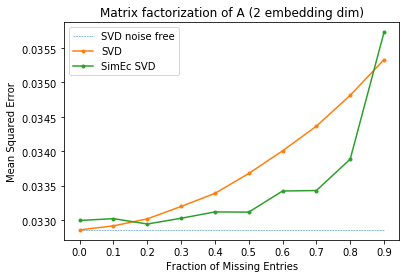

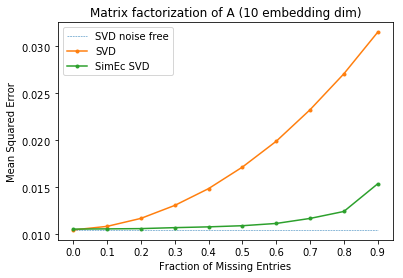

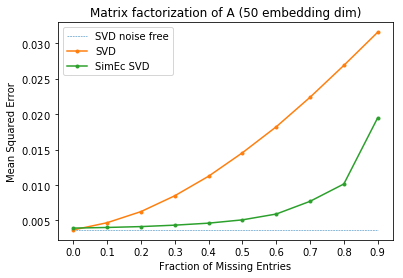

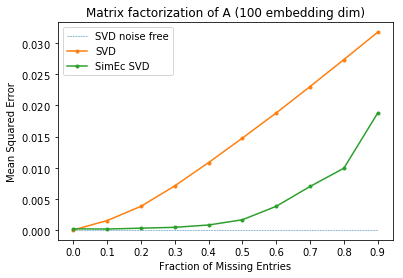

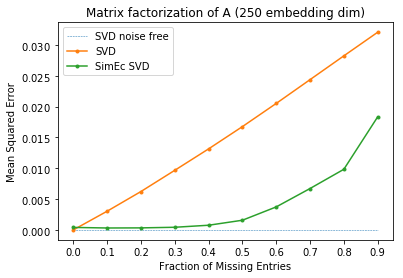

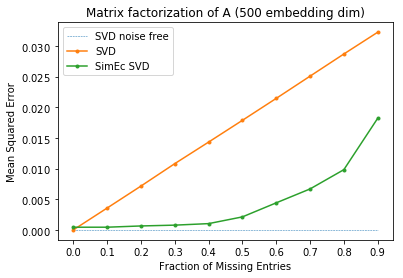

In [10]:
X = np.eye(n_input)
missing_targets = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
e_dims =  [2, 10, 50, 100, 250, 500]
for e_dim in e_dims:
    np.random.seed(15)
    mses = []
    mses_svd = []
    mse_svd = msqe(A, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim], Vh[:e_dim,:])))
    for m in missing_targets:
        print(m)
        A_noisy = A.copy()
        A_noisy[np.random.rand(*A_noisy.shape)<=m] = -100
        model = SimilarityEncoder(n_input, e_dim, n_output, mask_value=-100, l2_reg_emb=0.00001, 
                                  l2_reg_out=0. if m < 0.7 else 0.00001, opt=keras.optimizers.Adamax(lr=0.025 if e_dim < 50 else 0.01))
        model.fit(X, A_noisy, epochs=60)
        mse = msqe(A, model.predict(X))
        mses.append(mse)
        A_noisy[A_noisy == -100] = np.mean(A)
        U_n, s_n, Vh_n = np.linalg.svd(A_noisy, full_matrices=True)
        S_n = np.zeros((n_input, n_output))
        S_n[:n_input, :n_input] = np.diag(s_n)
        mses_svd.append(msqe(A, np.dot(U_n[:,:e_dim], np.dot(S_n[:e_dim,:e_dim], Vh_n[:e_dim,:]))))
    print(mses)
    plt.figure();
    plt.plot([0, missing_targets[-1]], [mse_svd, mse_svd], '--', linewidth=0.5, label='SVD noise free');
    plt.plot(missing_targets, mses_svd, '-o', markersize=3, label='SVD');
    plt.plot(missing_targets, mses, '-o', markersize=3, label='SimEc SVD');
    plt.legend(loc=0);
    plt.title('Matrix factorization of A (%i embedding dim)' % e_dim);
    plt.xticks(missing_targets, missing_targets);
    plt.xlabel('Fraction of Missing Entries');
    plt.ylabel('Mean Squared Error');

### Eigendecomposition of a square symmetric matrix

In [11]:
# get 2 square symmetric matrices as AA^T and A^TA
S1 = np.dot(A, A.T)
S2 = np.dot(A.T, A)
# make sure their range of values is still sort of reasonable (for >100 we should probably rescale)
np.max(S1), np.min(S1), np.max(S2), np.min(S2)

(59.695435723025966,
 -27.98543792640249,
 41.138757582464692,
 -20.548242102046601)

In [12]:
# the corresponding SVD eigenvalues and -vectors should work here as well
for e_dim in [2, 10, 25, 50, 75, 100, 250, 400, 500]:
    print("mse with %3i e_dim: %11.8f" % (e_dim, msqe(S1, np.dot(U[:,:e_dim], np.dot(S[:e_dim,:e_dim]**2, U.T[:e_dim,:])))))
S_out = np.zeros((n_output, n_output))
S_out[:n_input, :n_input] = S[:n_input, :n_input]
for e_dim in [2, 10, 25, 50, 75, 100, 250, 500, 700]:
    print("mse with %3i e_dim: %11.8f" % (e_dim, msqe(S2, np.dot(Vh.T[:,:e_dim], np.dot(S_out[:e_dim,:e_dim]**2, Vh[:e_dim,:])))))

mse with   2 e_dim: 31.81649696
mse with  10 e_dim:  1.06578559
mse with  25 e_dim:  0.22234735
mse with  50 e_dim:  0.12643778
mse with  75 e_dim:  0.05437228
mse with 100 e_dim:  0.00001633
mse with 250 e_dim:  0.00000222
mse with 400 e_dim:  0.00000009
mse with 500 e_dim:  0.00000000
mse with   2 e_dim: 16.23290661
mse with  10 e_dim:  0.54376816
mse with  25 e_dim:  0.11344252
mse with  50 e_dim:  0.06450907
mse with  75 e_dim:  0.02774096
mse with 100 e_dim:  0.00000833
mse with 250 e_dim:  0.00000113
mse with 500 e_dim:  0.00000000
mse with 700 e_dim:  0.00000000


In [13]:
# factorize the similarity matrix S1 with a simec
X = np.eye(n_input)
mses1 = []
mses2 = []
e_dims =  [2,   10,  25,  50,  75,  100,  250,  400,  500,  750,  1000]
l_rates = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01]
for i, e_dim in enumerate(e_dims):
    model = SimilarityEncoder(n_input, e_dim, S1.shape[1], s_ll_reg=1., S_ll=S1, opt=keras.optimizers.Adamax(lr=l_rates[i]))
    model.fit(X, S1, epochs=100)
    mse = msqe(S1, model.predict(X))
    mses1.append(mse)
    print("mse with %4i e_dim: %11.8f" % (e_dim, mse))
    # scalar product of emedding should also approximate S1
    Y = model.transform(X)
    mse = msqe(S1, np.dot(Y, Y.T))
    mses2.append(mse)
    print("mse with %4i e_dim: %11.8f" % (e_dim, mse))
for i, e_dim in enumerate(e_dims):
    print("mse with %4i e_dim: %11.8f (%11.8f)" % (e_dim, mses1[i], mses2[i]))

Epoch 1/100
500/500 [==============================] - 1s 3ms/step - loss: 82.1765
Epoch 2/100
500/500 [==============================] - 0s 101us/step - loss: 72.7879
Epoch 3/100
500/500 [==============================] - 0s 92us/step - loss: 68.2868
Epoch 4/100
500/500 [==============================] - 0s 106us/step - loss: 67.2929
Epoch 5/100
500/500 [==============================] - 0s 104us/step - loss: 66.8035
Epoch 6/100
500/500 [==============================] - 0s 99us/step - loss: 66.4628
Epoch 7/100
500/500 [==============================] - 0s 104us/step - loss: 66.1591
Epoch 8/100
500/500 [==============================] - 0s 112us/step - loss: 65.8954
Epoch 9/100
500/500 [==============================] - 0s 147us/step - loss: 65.6648
Epoch 10/100
500/500 [==============================] - 0s 105us/step - loss: 65.4632
Epoch 11/100
500/500 [==============================] - 0s 104us/step - loss: 65.2994
Epoch 12/100
500/500 [==============================] - 0s 89us/ste

500/500 [==============================] - 0s 95us/step - loss: 2.2615
Epoch 92/100
500/500 [==============================] - 0s 92us/step - loss: 2.2584
Epoch 93/100
500/500 [==============================] - 0s 92us/step - loss: 2.2582
Epoch 94/100
500/500 [==============================] - 0s 92us/step - loss: 2.2592
Epoch 95/100
500/500 [==============================] - 0s 103us/step - loss: 2.2603
Epoch 96/100
500/500 [==============================] - 0s 97us/step - loss: 2.2592
Epoch 97/100
500/500 [==============================] - 0s 106us/step - loss: 2.2604
Epoch 98/100
500/500 [==============================] - 0s 110us/step - loss: 2.2580
Epoch 99/100
500/500 [==============================] - 0s 116us/step - loss: 2.2571
Epoch 100/100
500/500 [==============================] - 0s 124us/step - loss: 2.2596
mse with   10 e_dim:  1.07445818
mse with   10 e_dim:  1.06854367
Epoch 1/100
500/500 [==============================] - 1s 3ms/step - loss: 72.2578
Epoch 2/100
500/50

500/500 [==============================] - 0s 99us/step - loss: 0.4423
Epoch 84/100
500/500 [==============================] - 0s 89us/step - loss: 0.4413
Epoch 85/100
500/500 [==============================] - 0s 85us/step - loss: 0.4404
Epoch 86/100
500/500 [==============================] - 0s 81us/step - loss: 0.4395
Epoch 87/100
500/500 [==============================] - 0s 99us/step - loss: 0.4377
Epoch 88/100
500/500 [==============================] - 0s 107us/step - loss: 0.4365
Epoch 89/100
500/500 [==============================] - 0s 92us/step - loss: 0.4348
Epoch 90/100
500/500 [==============================] - 0s 92us/step - loss: 0.4336
Epoch 91/100
500/500 [==============================] - 0s 108us/step - loss: 0.4327
Epoch 92/100
500/500 [==============================] - 0s 96us/step - loss: 0.4320
Epoch 93/100
500/500 [==============================] - 0s 102us/step - loss: 0.4315
Epoch 94/100
500/500 [==============================] - 0s 110us/step - loss: 0.4295
E

500/500 [==============================] - 0s 107us/step - loss: 0.2388
Epoch 76/100
500/500 [==============================] - 0s 91us/step - loss: 0.2359
Epoch 77/100
500/500 [==============================] - 0s 125us/step - loss: 0.2334
Epoch 78/100
500/500 [==============================] - 0s 100us/step - loss: 0.2309
Epoch 79/100
500/500 [==============================] - 0s 99us/step - loss: 0.2281
Epoch 80/100
500/500 [==============================] - 0s 104us/step - loss: 0.2250
Epoch 81/100
500/500 [==============================] - 0s 97us/step - loss: 0.2229
Epoch 82/100
500/500 [==============================] - 0s 106us/step - loss: 0.2201
Epoch 83/100
500/500 [==============================] - 0s 124us/step - loss: 0.2173
Epoch 84/100
500/500 [==============================] - 0s 107us/step - loss: 0.2155
Epoch 85/100
500/500 [==============================] - 0s 89us/step - loss: 0.2127
Epoch 86/100
500/500 [==============================] - 0s 107us/step - loss: 0.21

500/500 [==============================] - 0s 98us/step - loss: 0.1535
Epoch 72/100
500/500 [==============================] - 0s 113us/step - loss: 0.1527
Epoch 73/100
500/500 [==============================] - 0s 104us/step - loss: 0.1520
Epoch 74/100
500/500 [==============================] - 0s 100us/step - loss: 0.1513
Epoch 75/100
500/500 [==============================] - 0s 112us/step - loss: 0.1506
Epoch 76/100
500/500 [==============================] - 0s 102us/step - loss: 0.1499
Epoch 77/100
500/500 [==============================] - 0s 107us/step - loss: 0.1494
Epoch 78/100
500/500 [==============================] - 0s 112us/step - loss: 0.1493
Epoch 79/100
500/500 [==============================] - 0s 108us/step - loss: 0.1487
Epoch 80/100
500/500 [==============================] - 0s 127us/step - loss: 0.1481
Epoch 81/100
500/500 [==============================] - 0s 91us/step - loss: 0.1476
Epoch 82/100
500/500 [==============================] - 0s 103us/step - loss: 0.

500/500 [==============================] - 0s 118us/step - loss: 0.3168
Epoch 62/100
500/500 [==============================] - 0s 112us/step - loss: 0.3066
Epoch 63/100
500/500 [==============================] - 0s 129us/step - loss: 0.2977
Epoch 64/100
500/500 [==============================] - 0s 115us/step - loss: 0.2897
Epoch 65/100
500/500 [==============================] - 0s 122us/step - loss: 0.2822
Epoch 66/100
500/500 [==============================] - 0s 112us/step - loss: 0.2747
Epoch 67/100
500/500 [==============================] - 0s 137us/step - loss: 0.2683
Epoch 68/100
500/500 [==============================] - 0s 111us/step - loss: 0.2625
Epoch 69/100
500/500 [==============================] - 0s 125us/step - loss: 0.2568
Epoch 70/100
500/500 [==============================] - 0s 133us/step - loss: 0.2515
Epoch 71/100
500/500 [==============================] - 0s 127us/step - loss: 0.2463
Epoch 72/100
500/500 [==============================] - 0s 109us/step - loss: 

500/500 [==============================] - 0s 148us/step - loss: 0.2656
Epoch 52/100
500/500 [==============================] - 0s 151us/step - loss: 0.2586
Epoch 53/100
500/500 [==============================] - 0s 148us/step - loss: 0.2522
Epoch 54/100
500/500 [==============================] - 0s 138us/step - loss: 0.2464
Epoch 55/100
500/500 [==============================] - 0s 140us/step - loss: 0.2409
Epoch 56/100
500/500 [==============================] - 0s 150us/step - loss: 0.2360
Epoch 57/100
500/500 [==============================] - 0s 149us/step - loss: 0.2313
Epoch 58/100
500/500 [==============================] - 0s 145us/step - loss: 0.2267
Epoch 59/100
500/500 [==============================] - 0s 141us/step - loss: 0.2226
Epoch 60/100
500/500 [==============================] - 0s 145us/step - loss: 0.2188
Epoch 61/100
500/500 [==============================] - 0s 151us/step - loss: 0.2153
Epoch 62/100
500/500 [==============================] - 0s 145us/step - loss: 

In [14]:
# factorize the similarity matrix S2 with a simec
X = np.eye(n_output)
mses1 = []
mses2 = []
e_dims =  [2,   10,  25,  50,  75,  100,  250,  400,  500,  750,  1000]
l_rates = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01]
for i, e_dim in enumerate(e_dims):
    model = SimilarityEncoder(n_output, e_dim, S2.shape[1], s_ll_reg=1., S_ll=S2, opt=keras.optimizers.Adamax(lr=l_rates[i]))
    model.fit(X, S2, epochs=60)
    mse = msqe(S2, model.predict(X))
    mses1.append(mse)
    print("mse with %4i e_dim: %11.8f" % (e_dim, mse))
    # scalar product of emedding should also approximate S1
    Y = model.transform(X)
    mse = msqe(S2, np.dot(Y, Y.T))
    mses2.append(mse)
    print("mse with %4i e_dim: %11.8f" % (e_dim, mse))
for i, e_dim in enumerate(e_dims):
    print("mse with %4i e_dim: %11.8f (%11.8f)" % (e_dim, mses1[i], mses2[i]))

Epoch 1/60
700/700 [==============================] - 2s 2ms/step - loss: 40.0727
Epoch 2/60
700/700 [==============================] - 0s 107us/step - loss: 36.0504
Epoch 3/60
700/700 [==============================] - 0s 116us/step - loss: 34.5160
Epoch 4/60
700/700 [==============================] - 0s 124us/step - loss: 34.1153
Epoch 5/60
700/700 [==============================] - 0s 125us/step - loss: 33.8413
Epoch 6/60
700/700 [==============================] - 0s 112us/step - loss: 33.6295
Epoch 7/60
700/700 [==============================] - 0s 119us/step - loss: 33.4654
Epoch 8/60
700/700 [==============================] - 0s 109us/step - loss: 33.3230
Epoch 9/60
700/700 [==============================] - 0s 111us/step - loss: 33.2054
Epoch 10/60
700/700 [==============================] - 0s 104us/step - loss: 33.0919
Epoch 11/60
700/700 [==============================] - 0s 109us/step - loss: 33.0030
Epoch 12/60
700/700 [==============================] - 0s 105us/step - loss:

700/700 [==============================] - 0s 91us/step - loss: 0.7213
Epoch 14/60
700/700 [==============================] - 0s 110us/step - loss: 0.6389
Epoch 15/60
700/700 [==============================] - 0s 106us/step - loss: 0.5770
Epoch 16/60
700/700 [==============================] - 0s 101us/step - loss: 0.5293
Epoch 17/60
700/700 [==============================] - 0s 96us/step - loss: 0.4940
Epoch 18/60
700/700 [==============================] - 0s 103us/step - loss: 0.4666
Epoch 19/60
700/700 [==============================] - 0s 97us/step - loss: 0.4442
Epoch 20/60
700/700 [==============================] - 0s 92us/step - loss: 0.4264
Epoch 21/60
700/700 [==============================] - 0s 109us/step - loss: 0.4125
Epoch 22/60
700/700 [==============================] - 0s 108us/step - loss: 0.4002
Epoch 23/60
700/700 [==============================] - 0s 112us/step - loss: 0.3901
Epoch 24/60
700/700 [==============================] - 0s 118us/step - loss: 0.3820
Epoch 25

700/700 [==============================] - 0s 125us/step - loss: 0.1954
Epoch 27/60
700/700 [==============================] - 0s 120us/step - loss: 0.1913
Epoch 28/60
700/700 [==============================] - 0s 116us/step - loss: 0.1874
Epoch 29/60
700/700 [==============================] - 0s 103us/step - loss: 0.1841
Epoch 30/60
700/700 [==============================] - 0s 108us/step - loss: 0.1810
Epoch 31/60
700/700 [==============================] - 0s 116us/step - loss: 0.1781
Epoch 32/60
700/700 [==============================] - 0s 121us/step - loss: 0.1754
Epoch 33/60
700/700 [==============================] - 0s 112us/step - loss: 0.1730
Epoch 34/60
700/700 [==============================] - 0s 118us/step - loss: 0.1705
Epoch 35/60
700/700 [==============================] - 0s 123us/step - loss: 0.1684
Epoch 36/60
700/700 [==============================] - 0s 120us/step - loss: 0.1664
Epoch 37/60
700/700 [==============================] - 0s 129us/step - loss: 0.1643
Epoc

700/700 [==============================] - 0s 139us/step - loss: 0.2542
Epoch 38/60
700/700 [==============================] - 0s 150us/step - loss: 0.2440
Epoch 39/60
700/700 [==============================] - 0s 140us/step - loss: 0.2352
Epoch 40/60
700/700 [==============================] - 0s 144us/step - loss: 0.2272
Epoch 41/60
700/700 [==============================] - 0s 167us/step - loss: 0.2204
Epoch 42/60
700/700 [==============================] - 0s 152us/step - loss: 0.2142
Epoch 43/60
700/700 [==============================] - 0s 151us/step - loss: 0.2088
Epoch 44/60
700/700 [==============================] - 0s 150us/step - loss: 0.2040
Epoch 45/60
700/700 [==============================] - 0s 149us/step - loss: 0.1996
Epoch 46/60
700/700 [==============================] - 0s 144us/step - loss: 0.1958
Epoch 47/60
700/700 [==============================] - 0s 148us/step - loss: 0.1923
Epoch 48/60
700/700 [==============================] - 0s 144us/step - loss: 0.1892
Epoc